In [34]:
Income = {
    'df': 'income_onehot.csv',
    'pa': 'sex',
    'label': 'label',
}

COMPAS = {
    'df': 'compas_onehot.csv',
    'pa': 'race',
    'label': 'label',
}

German = {
    'df': 'german_onehot.csv',
    'pa': 'gender',
    'label': 'label',
}

DSets = {
    'Income': Income,
    'COMPAS': COMPAS,
    'German': German,
}

##  Loading analysis ready data from Vlad's github

In [35]:
import pandas as pd
import numpy as np

# Set desired Dataset here, values can be: 'Income', 'COMPAS', 'German'
dset = 'Income'

url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'
df = pd.read_csv(url + DSets[dset]['df'], header=0)
pa = DSets[dset]['pa']
label = DSets[dset]['label']

## Splitting data for train/test in 0.9/0.1 proportion

In [36]:
def ttSplit(df, ts=0.10):
    """Train / Test split dataframe df with test proportion ts"""
    
    from sklearn.model_selection import train_test_split

    train, test = train_test_split(df, test_size=ts)

    X_test = test.drop([label], axis=1).values
    y_test = test[label].values

        
    ttdict = {
        'train': train,
        'test': test,
        'X_test': X_test,
        'y_test': y_test,
        
    }

    return ttdict

In [37]:
ttdict = ttSplit(df)

## Function to ascertain "favoured" subgroup

In [38]:
def findFav(ttdict, pa=pa, label=label):
    train = ttdict['train']

    pos_rates = [train[(train[pa] == u) & (train[label] == 1)].shape[0] / train[train[pa] == u].shape[0]
                 for u in train[pa].unique()]
    max_value = max(pos_rates)
    max_index = pos_rates.index(max_value)

    # Favoured group
    fav = train[pa].unique()[max_index]
    return fav

In [39]:
fav = findFav(ttdict)

In [40]:
fav

1

## Function for preferential resampling 

In [41]:
def fairCorrectPSP(df, pa, fav, d=1):
    from sklearn.naive_bayes import GaussianNB as nb
    import math
    
    df2 = df.copy()
    
    # Train NB model and get prediction confidence
    Xnb = df.drop([label], axis=1).values
    ynb = df[label].values
    
    model = nb()
    model.fit(Xnb, ynb)
    logProbs = model.predict_log_proba(Xnb)
    df2['pPos'] = [logProbs[i][1] for i in range(len(logProbs))]
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = (df2[(df2[pa] == fav) & (df2[label] == 1)]
               .sort_values('pPos', ascending=True))
    fav_neg = (df2[(df2[pa] == fav) & (df2[label] == 0)]
               .sort_values('pPos', ascending=False))
    unfav_pos = (df2[(df2[pa] != fav) & (df2[label] == 1)]
                 .sort_values('pPos', ascending=True))
    unfav_neg = (df2[(df2[pa] != fav) & (df2[label] == 0)]
                 .sort_values('pPos', ascending=False))
    
    # drop aux columns
    fav_pos = fav_pos.drop(['pPos'], axis=1)
    fav_neg = fav_neg.drop(['pPos'], axis=1)
    unfav_pos = unfav_pos.drop(['pPos'], axis=1)
    unfav_neg = unfav_neg.drop(['pPos'], axis=1)
    
    if d < 1:

        # get favoured and unfavoured number of rows
        fav_size = fav_pos.shape[0] + fav_neg.shape[0]
        unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

        # get positive ratios for favoured and unfavoured
        fav_pr = fav_pos.shape[0] / fav_size
        unfav_pr = unfav_pos.shape[0] / unfav_size
        pr = df[df[label] == 1].shape[0] / df.shape[0]

        # coefficients for fitting quad function
        a = ((fav_pr + unfav_pr) / 2) - pr
        b = (fav_pr - unfav_pr) / 2
        c = pr

        # corrected ratios
        corr_fpr = (a * (d ** 2)) + (b * d) + c
        corr_upr = (a * (d ** 2)) - (b * d) + c

        # number of elements to remove or add
        fav_move = math.floor((fav_pr - corr_fpr) * fav_size)
        unfav_move = math.floor((corr_upr - unfav_pr) * unfav_size)

        # elements to add
        ext_fn = pd.concat([fav_neg] * math.ceil(fav_move / fav_neg.shape[0]), ignore_index=True)
        ext_up = pd.concat([unfav_pos] * math.ceil(unfav_move / unfav_pos.shape[0]), ignore_index=True)
    
        # remove from fp and un
        fav_pos = fav_pos.tail(fav_pos.shape[0] - fav_move)
        unfav_neg = unfav_neg.tail(unfav_neg.shape[0] - unfav_move)
    
        # add to fn and up
        fav_neg = pd.concat([fav_neg, ext_fn.head(fav_move)], ignore_index=True) 
        unfav_pos = pd.concat([unfav_pos, ext_up.head(unfav_move)], ignore_index=True)
    
    # concatenate df's
    corr_dfs = [fav_pos, fav_neg, unfav_pos, unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

## Function that returns "corrected" training set of different d values   

In [42]:
def correctTrains(train, pa, fav, FCfun= fairCorrectPSP):
    corr_trains = []
    Xs = []
    ys = []
    ds =[]

    for i in range(11):
        tdf = FCfun(train, pa, fav, d=1-(0.2*i))
        corr_trains.append(tdf)
        
    for i in range(11):
        X = corr_trains[i].drop([label], axis=1).values
        y = corr_trains[i][label].values
        Xs.append(X)
        ys.append(y)
    
    corrected = {
        'corr_trains': corr_trains,
        'Xs': Xs,
        'ys': ys,
    }
    
    return corrected


In [43]:
faircorrected = correctTrains(ttdict['train'],pa, fav)

## Function that trains model on given training datasets and predicts for test set 

In [47]:
def makePreds(Xs, ys, X_test):
    from sklearn.linear_model import LogisticRegression

    models = []
    preds = []
    classpred = []
    

    for i in range(11):
        model = LogisticRegression(max_iter=10000)
        model.fit(Xs[i], ys[i])
        models.append(model)
        
    
        p = model.predict_proba(X_test)[:, 1]
        cp = model.predict(X_test)
        classpred.append(cp)
        preds.append(p)
    
    outputs = {
        'models': models,
        'preds': preds,
        'classpred' : classpred,
        
    }
    
    return outputs

In [48]:
allDataOutputs= makePreds(faircorrected['Xs'], faircorrected['ys'], ttdict['X_test'])


##  Reconstructing the test sets i.e. adding predictions  

In [49]:
classpred = []
for i in range(11):
    dfcp = pd.DataFrame(allDataOutputs['classpred'][i])
    dfpc =dfcp.rename(columns={0: "classpred"})
    classpred.append(dfpc)

In [50]:

preds = []
for i in range(11):
    df = pd.DataFrame(allDataOutputs['preds'][i])
    df =df.rename(columns={0: "preds"})
    preds.append(df)


In [51]:
dfalltest= ttdict['test']
allDfList =[]
for i in range(11):
    dfp = preds[i]
    dfcp = classpred[i]
    dfout = dfalltest.copy()
    dfout['preds'] = dfp['preds'].values
    dfout['classpred'] = dfcp['classpred'].values
    allDfList.append(dfout)
                         
                         

## Functions for Five Nuanced Machine Learning Bias Metrics  

In [52]:
def calculate_sub_auc(allDfList):
    from sklearn import metrics
        
    aucScore = []
    
    for i in range(11):
        dff= allDfList[i]
        dfsub = dff.loc[(dff[pa] == 0)]
        true_labels = dfsub['label'].values
        predicted_labels = dfsub['preds'].values
        auc= metrics.roc_auc_score(true_labels, predicted_labels)
        aucScore.append(auc)

    
    return aucScore

In [53]:
def calculate_bpsn_auc(allDfList):
    from sklearn import metrics
        
    aucScore = []
    
    for i in range(11):
        dff= allDfList[i]
        dffiltered= dff.loc[( ((dff[pa] == 1) & (dff[label] == 1)) |((dff[pa] == 0) & (dff[label] == 0)) )]
        true_labels = dffiltered['label'].values
        predicted_labels = dffiltered['preds'].values
        auc= metrics.roc_auc_score(true_labels, predicted_labels)
        aucScore.append(auc)

    
    return aucScore

In [54]:
def calculate_bnsp_auc(allDfList):
    from sklearn import metrics
        
    aucScore = []
    
    for i in range(11):
        dff= allDfList[i]
        dffiltered= dff.loc[( ((dff[pa] == 1) & (dff[label] == 0)) |((dff[pa] == 0) & (dff[label] == 1)) )]
        true_labels = dffiltered['label'].values
        predicted_labels = dffiltered['preds'].values
        auc= metrics.roc_auc_score(true_labels, predicted_labels)
        aucScore.append(auc)

    
    return aucScore

In [75]:
def normalized_mwu(data1, data2):

    import scipy.stats as stats
    scores_1 = data1
    scores_2 = data2
    n1 = len(scores_1)
    n2 = len(scores_2)
    if n1 == 0 or n2 == 0:
        return None
    u, _ = stats.mannwhitneyu(scores_1, scores_2, alternative='less')
    return u / (n1 * n2)

In [76]:
def compute_positive_aeg(allDfList):
    paeg = []
    for i in range(11):
        dff= allDfList[i]
        data1 = dff.loc[((dff[pa] == 1) & (dff[label] == 1))]
        data2 = dff.loc[((dff[pa] == 0) & (dff[label] == 1))]
        data1 = data1['preds'].values
        data2 = data2['preds'].values
        mwu = normalized_mwu(data1, data2)
    
        pag= 0.5 - mwu
        paeg.append(pag)


    return paeg

In [77]:
def compute_negative_aeg(allDfList):
    naeg = []
    for i in range(11):
        dff= allDfList[i]
        data1 = dff.loc[((dff[pa] == 1) & (dff[label] == 0))]
        data2 = dff.loc[((dff[pa] == 0) & (dff[label] == 0))]
        data1 = data1['preds'].values
        data2 = data2['preds'].values
        mwu = normalized_mwu(data1, data2)
        if mwu is None:
            return None
        nag= 0.5 - mwu
        naeg.append(nag)


    return naeg

In [78]:
subAuc = calculate_sub_auc(allDfList)
bpsnAuc = calculate_bpsn_auc(allDfList)
bnspAuc = calculate_bnsp_auc(allDfList)
pAEGScore = compute_positive_aeg(allDfList)
nAEGScore = compute_negative_aeg(allDfList)

In [79]:
subAuc

[0.9289025359928268,
 0.9281073948129727,
 0.9258657734016816,
 0.9227782571182054,
 0.9211118442200004,
 0.9232181224517417,
 0.9239540509905428,
 0.9216616758869208,
 0.9240809352213707,
 0.9238694615033244,
 0.9211456800148878]

In [80]:
bpsnAuc

[0.9742516500955606,
 0.9459903535273229,
 0.9167874814101183,
 0.8937921487564655,
 0.8611082531279326,
 0.8258412603394037,
 0.7877822778022004,
 0.7443154714581014,
 0.6981985352576394,
 0.640165368103037,
 0.5468885916586383]

In [81]:
bnspAuc

[0.7722303365887688,
 0.8519031217300315,
 0.8920855859783746,
 0.9097161667247994,
 0.9302461196372516,
 0.9541986396930588,
 0.9674856121381235,
 0.9759929804673876,
 0.9837101063829787,
 0.98925815312173,
 0.9933674136728287]

In [82]:
pAEGScore

[-0.13425536129958893,
 -0.01607151701253029,
 0.0782279233321777,
 0.12873309890545293,
 0.17696003169729085,
 0.22189341785944233,
 0.2519315536625229,
 0.2775617849536922,
 0.29453717002624935,
 0.31271358526075976,
 0.32827745034916544]

In [83]:
nAEGScore

[-0.2390522418373845,
 -0.12994381683244405,
 -0.06072420569571613,
 -0.01199690402476783,
 0.049072442526842786,
 0.10045108468919484,
 0.15416749006433478,
 0.1952646400105395,
 0.25017565816920273,
 0.3013614880442659,
 0.365216663373076]

In [84]:
from sklearn.metrics import accuracy_score
accs = []
for i in range(11):
        dff= allDfList[i]
        true_labels = dff['label'].values
        classpredicted_labels = dff['classpred'].values
        acc= accuracy_score(true_labels, classpredicted_labels)
        accs.append(acc)

    


In [85]:
accs

[0.8513969910961007,
 0.8458704329137243,
 0.842493091802272,
 0.8437212158428001,
 0.8366595026097636,
 0.829597789376727,
 0.8252993552348787,
 0.815781393920786,
 0.8062634326066933,
 0.801657967454713,
 0.7933681301811483]

In [86]:
dValues =[]
for i in range(11):
    D=1-(0.2*i)
    dValues.append(D)

## Plots 

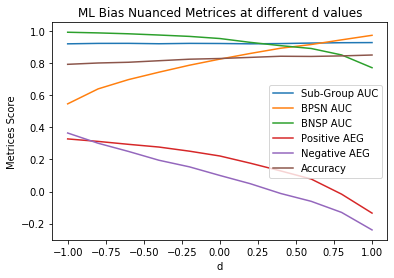

In [87]:
from matplotlib import pyplot as plt

plt.plot(dValues, subAuc)
plt.plot(dValues,bpsnAuc)
plt.plot(dValues, bnspAuc)
plt.plot(dValues, pAEGScore)
plt.plot(dValues, nAEGScore)
plt.plot(dValues, accs)
plt.title("ML Bias Nuanced Metrices at different d values")
plt.xlabel("d")
plt.ylabel("Metrices Score" )
plt.legend(["Sub-Group AUC", "BPSN AUC", "BNSP AUC", "Positive AEG", "Negative AEG", "Accuracy"])
plt.show()

In [66]:
overallplot= allDfList[0]
subplot = overallplot.loc[(overallplot[pa] == 0)]


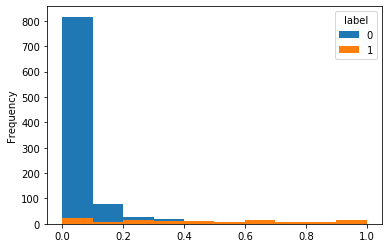

In [67]:
subplot.pivot(columns="label", values="preds").plot.hist(bins=10)

plt.show()

## Redundant functions  

In [68]:
def calculate_overall_auc(allDfList):
    from sklearn import metrics
        
    aucScore = []
    
    for i in range(11):
        dff= allDfList[i]
        true_labels = dff['label'].values
        predicted_labels = dff['preds'].values
        auc= metrics.roc_auc_score(true_labels, predicted_labels)
        aucScore.append(auc)

    
    return aucScore


In [69]:
overallAuc= calculate_overall_auc(allDfList)

In [70]:
overallAuc

[0.9049151757346693,
 0.9028721931554667,
 0.8960417921717818,
 0.8892624528582156,
 0.8789722368931397,
 0.8716198721704614,
 0.8604389137377556,
 0.8452483247646005,
 0.830863375475544,
 0.8114398256269755,
 0.7787046531107389]